This example tests whether an approach that uses empirical characteristic functions (ECFs) can detect differences in models with different variance of sampled parameters. 

In [1]:
from matplotlib import pyplot as plt
import ipywidgets as ipw
from IPython.display import display
import numpy as np
import pandas as pd

from stochastic_models import model_sir
from stochastic_tests import Test
import stochastic_repro as sr

t_fin = 10.0
num_steps = 100
test_kwargs = dict(t_fin=t_fin, 
                   num_steps=num_steps, 
                   sample_times=[t_fin / num_steps * i for i in range(0, num_steps + 1)], 
                   trials=[100, 500, 1000, 5000, 10000])

beta_mean = 2.0E-6
beta_stdev = beta_mean / 10
beta1_stdev = beta_stdev
beta2_stdev = beta_stdev * 1.25

test1 = Test(model=model_sir({'beta': ('norm', (beta_mean, beta1_stdev))}), stochastic=False, **test_kwargs)
test2 = Test(model=model_sir({'beta': ('norm', (beta_mean, beta2_stdev))}), stochastic=False, **test_kwargs)
tests = [test1, test2]

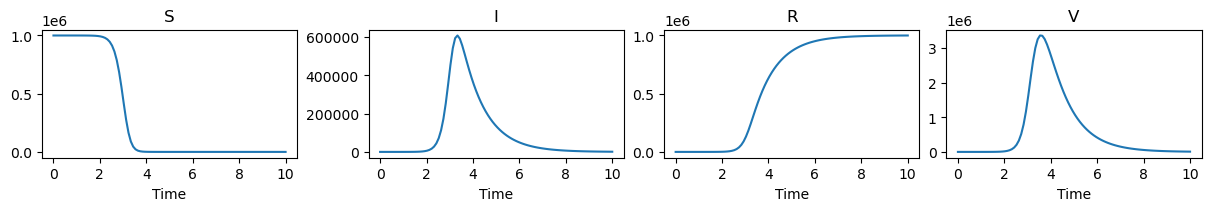

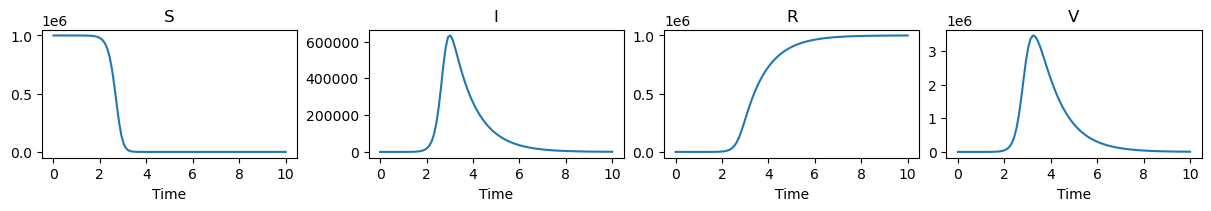

In [2]:
for test in tests:
    test.execute_deterministic()
    _ = test.plot_results_deterministic()

In [3]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

for test in tests:
    test.execute_stochastic(label)
_ = out.clear_output()

Output()

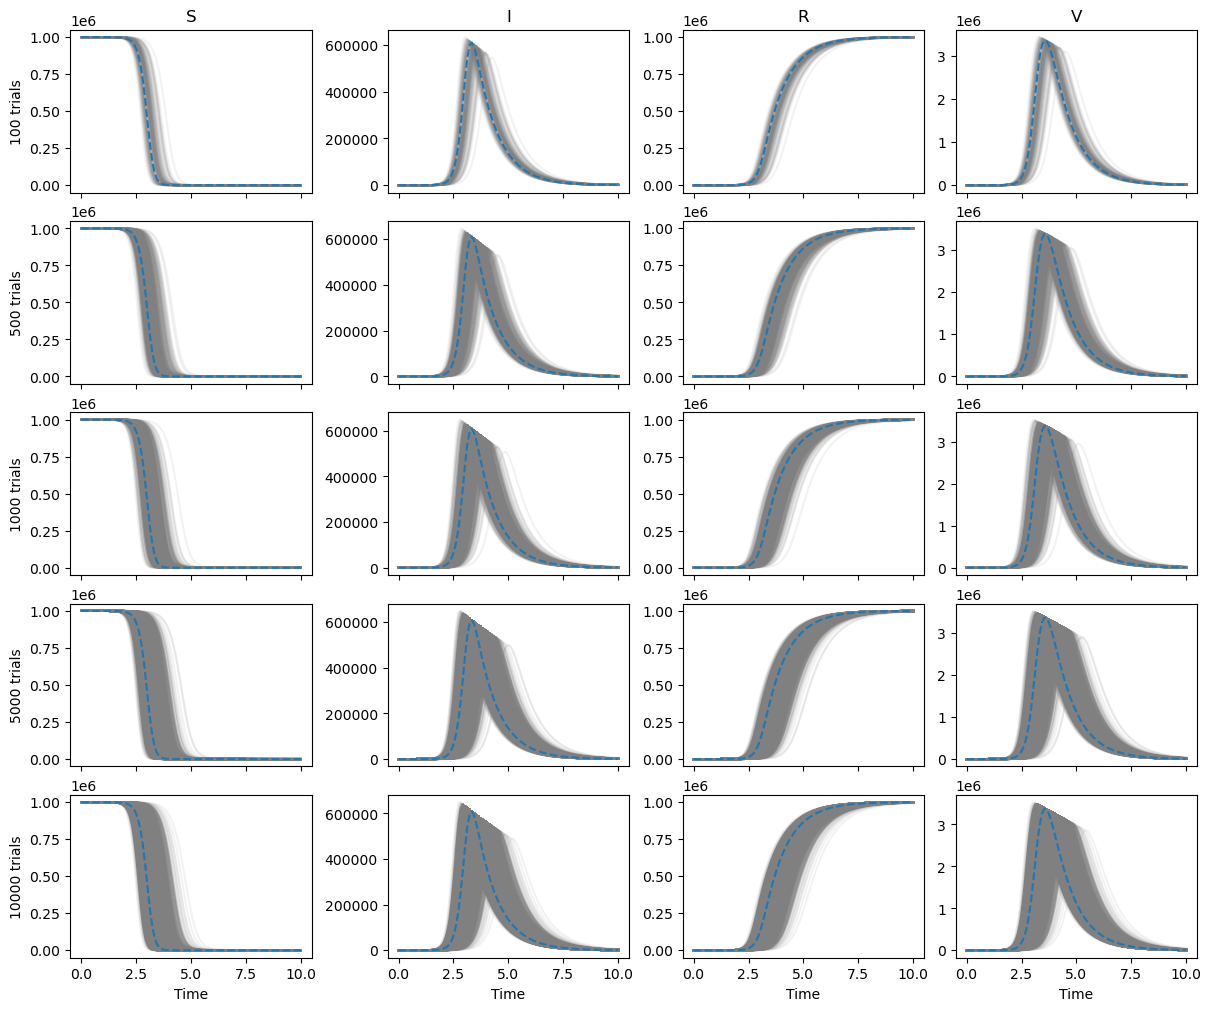

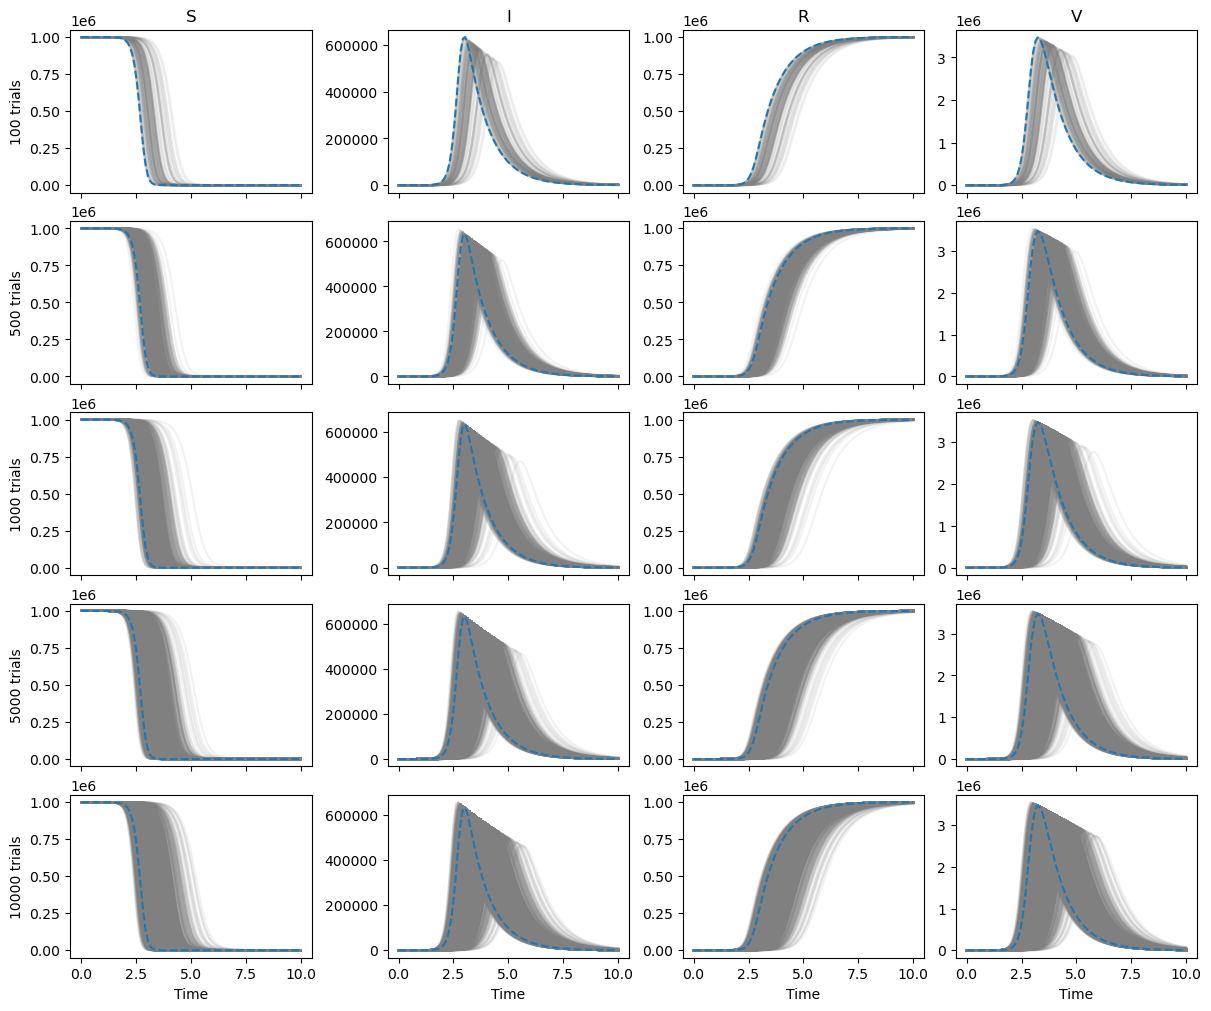

In [4]:
for test in tests:
    _ = test.plot_results_stochastic()

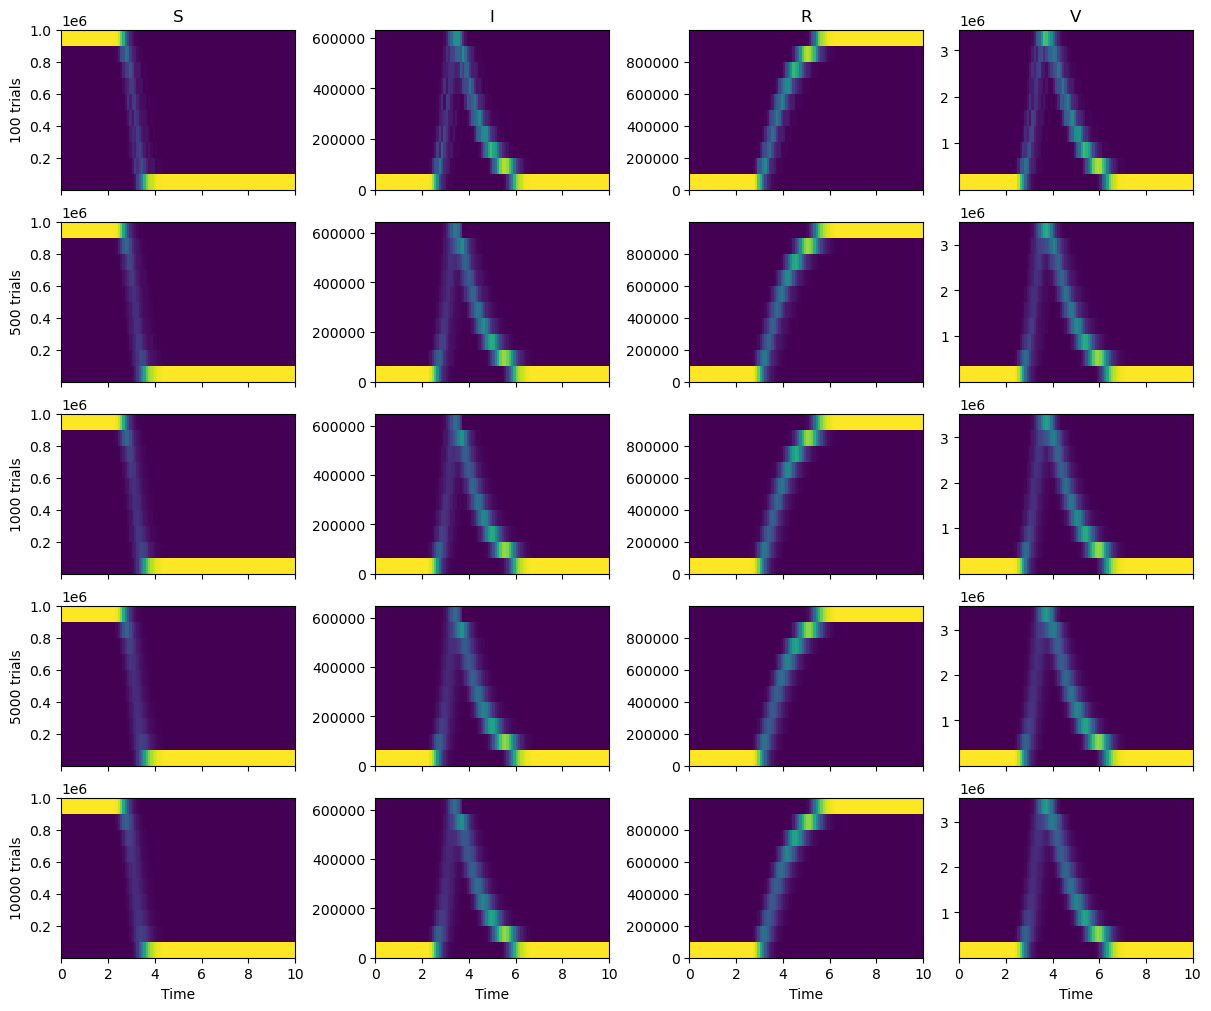

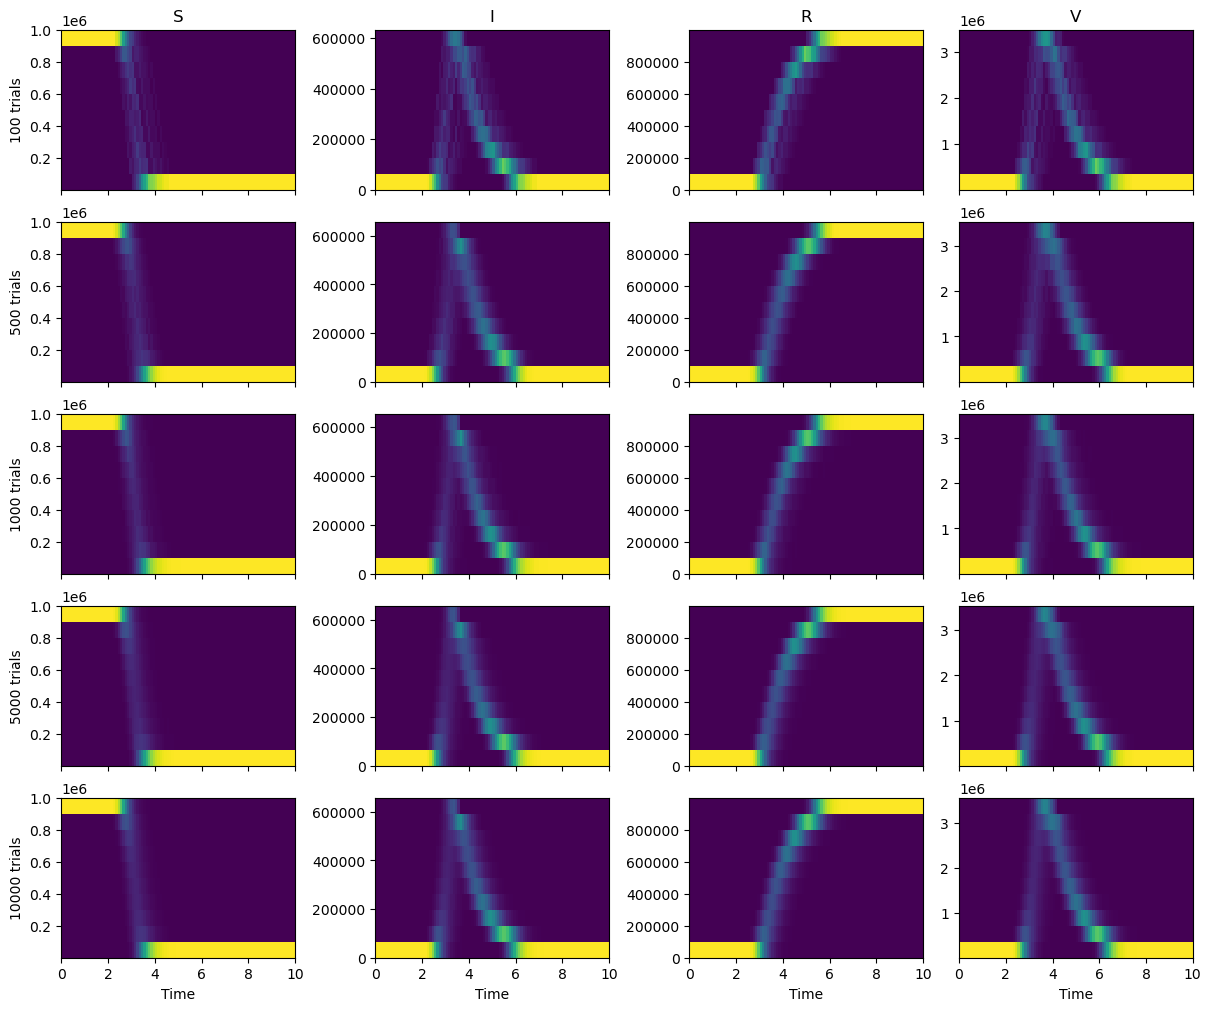

In [5]:
for test in tests:
    _ = test.plot_distributions()

/Users/timothy.sego/PycharmProjects/ssr_project_2024/code/stochastic_repro.py:992: OptimizeWarning: Covariance of the parameters could not be estimated
  return curve_fit(fit_func, data_x, data_y, **kwargs)


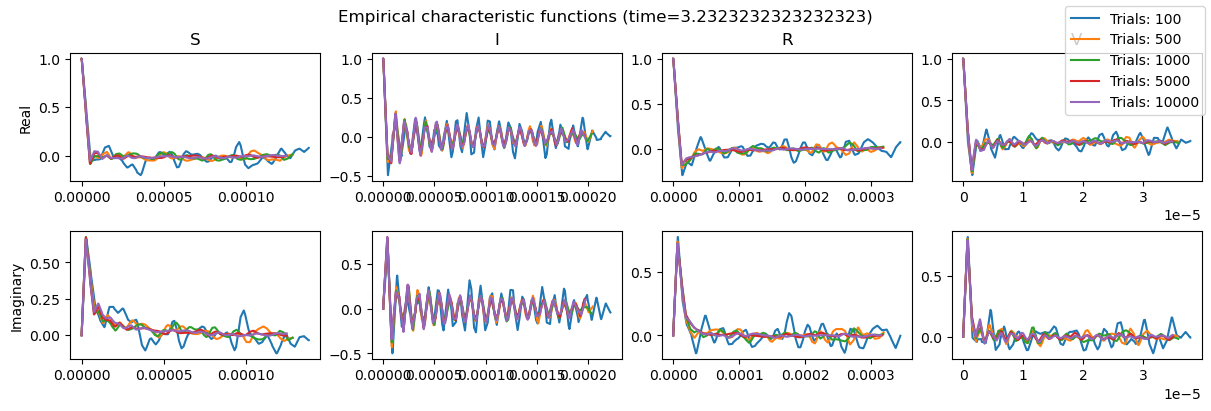

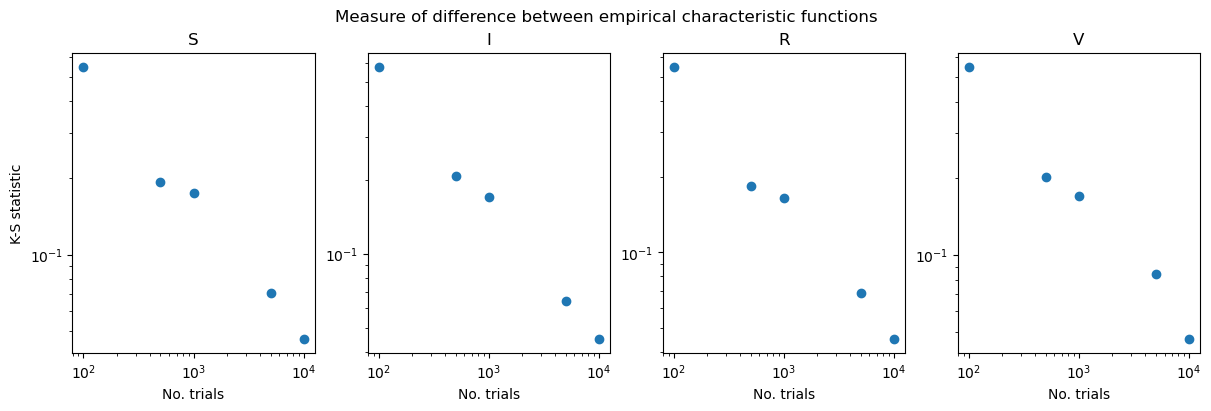

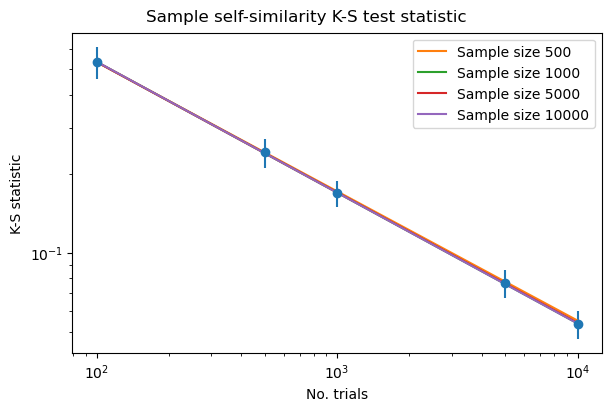

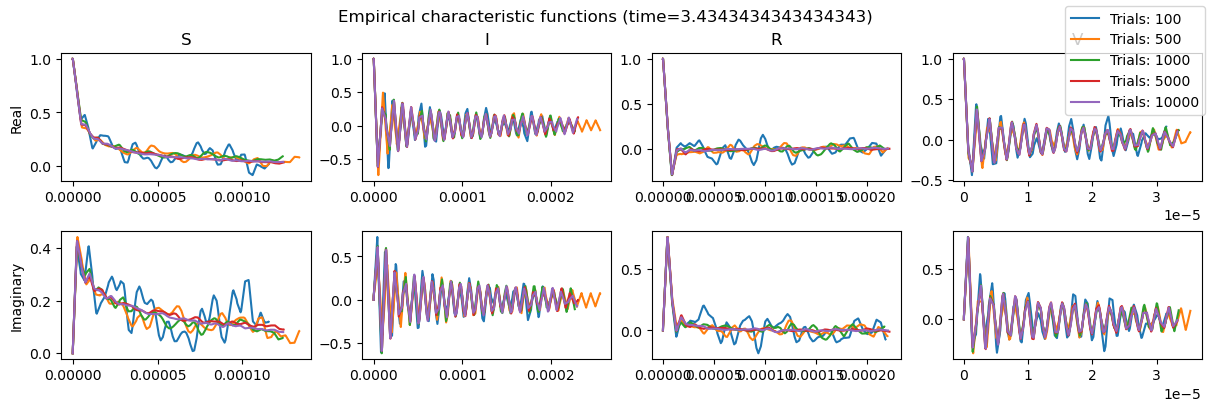

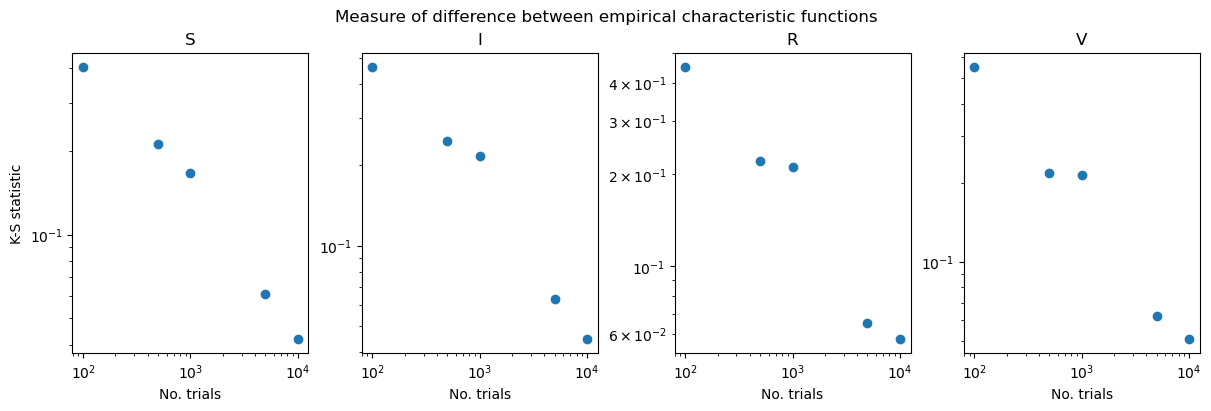

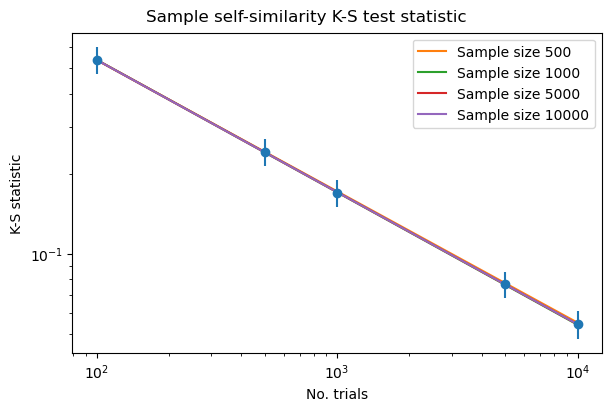

In [6]:
for test in [test1, test2]:
    test.find_ecfs()
    test.measure_ecf_diffs()
    test.plot_ecf(test.max_ks_stat_time(test.trials[-1]))
    test.plot_ecf_diffs()
    test.test_sampling(err_thresh=1E-3)
    test.generate_ecf_sampling_fits()
    _, ax = test.plot_ecf_sampling_fits(test.plot_ecf_sampling())
    _ = ax.legend()

test1.save('proto_compare_6_test1.json')
test2.save('proto_compare_6_test2.json')

Comparing the converged ECF of the two models, we should find that they are always quantifiably different since their models have different parameters.

Text(0.5, 0.98, 'Measure of empirical characteristic functions')

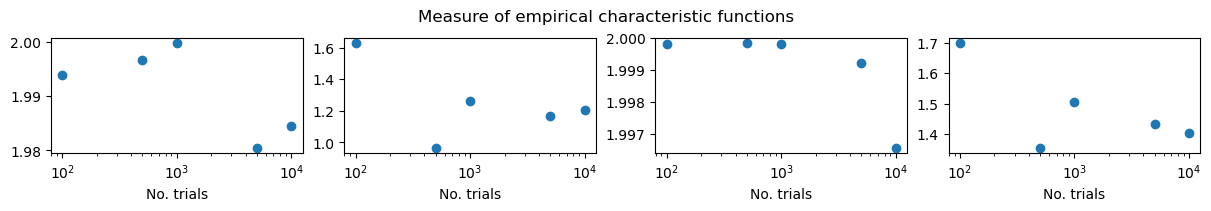

In [7]:
ecf_diff = sr.measure_ecf_diff_sets(test1.ecf, test2.ecf)

fig, ax = plt.subplots(1, len(test1.model.results_names), sharey=False, figsize=(12.0, 2.0), layout='compressed')
for i, name in enumerate(test1.model.results_names):
    ax[i].scatter(test1.trials, [max([el[name] for el in ecf_diff[trial]]) for trial in test1.trials])
    ax[i].set_xlabel('No. trials')
    ax[i].set_xscale('log')
fig.suptitle('Measure of empirical characteristic functions')

Testing for how well the method can detect differences in variance of model parameters. 

Output()

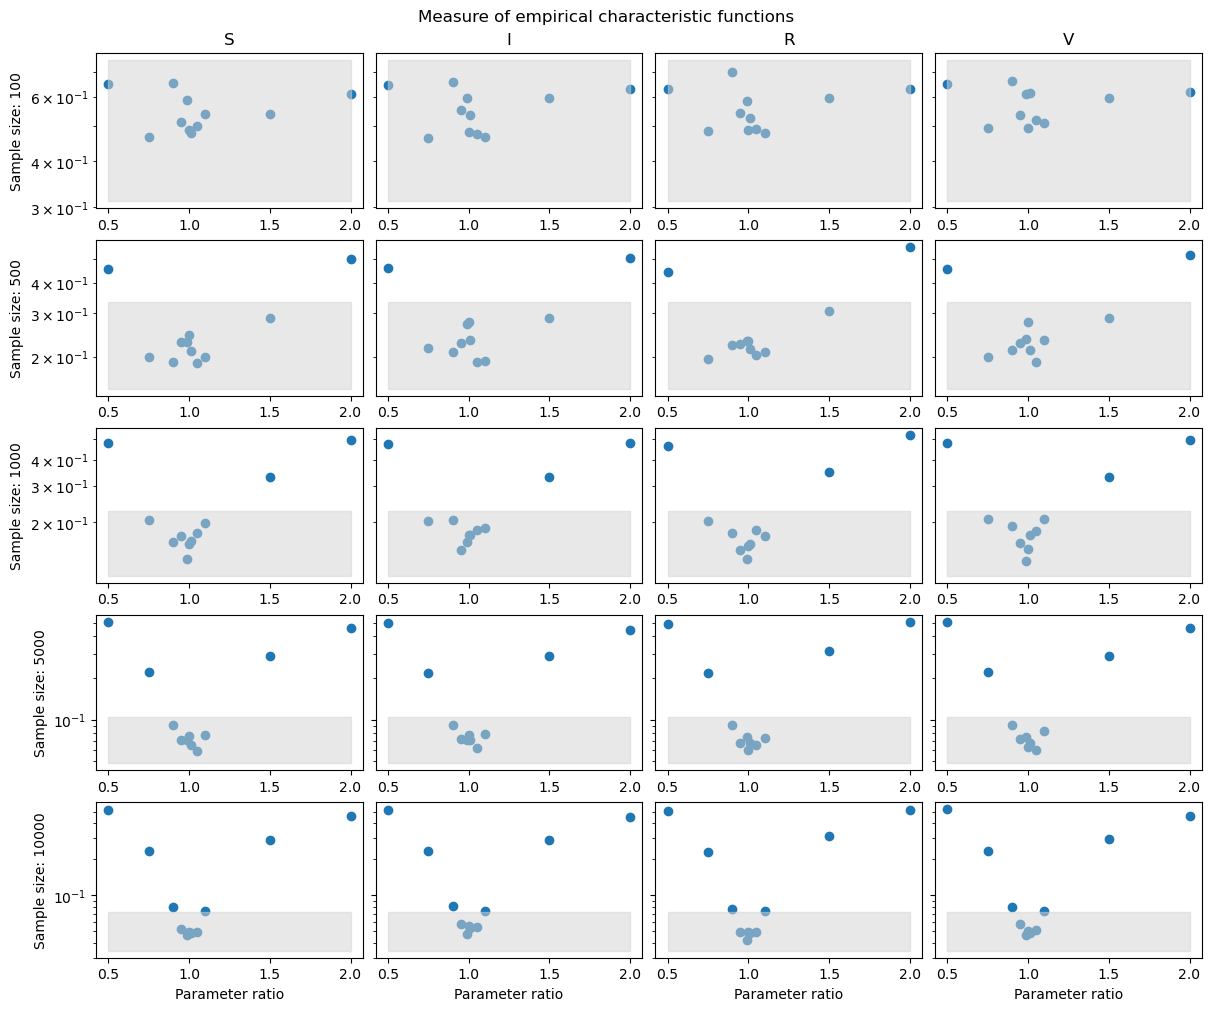

In [9]:
beta_fact = [0.5, 0.75, 0.9, 0.95, 0.99, 1.0, 1.01, 1.05, 1.1, 1.5, 2.0]
beta_comp = list()
test_test_kwargs = test_kwargs.copy()
test_test_kwargs['trials'] = [int(t / 2) for t in test_kwargs['trials']]

label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

# Make half-size tests
test1_sims_hs = {}
ecf_eval_info = {}
for trials in test1.trials:
    ht = int(trials / 2)
    simset = sr.SimSet(model=test1.model, num_trials=ht, stochastic=False, num_steps=test_kwargs['num_steps'], t_fin=test_kwargs['t_fin'])
    simset.results = {k: v[:ht, :] for k, v in test1.sims_s[trials].results.items()}
    simset.results_time = test1.sims_s[trials].results_time
    test1_sims_hs[ht] = simset
    ecf_eval_info[ht] = test1.ecf_eval_info[trials]
ecf1 = sr.generate_ecfs(test1_sims_hs, test1.sample_times, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)

for bf in beta_fact:
    label.value = f'Factor: {bf}...'

    betatest_stdev = beta_stdev * bf
    test = Test(model=model_sir({'beta': ('norm', (beta_mean, betatest_stdev))}), stochastic=False, **test_test_kwargs)
    test.execute_stochastic()
    ecf2 = sr.generate_ecfs(test.sims_s, test1.sample_times, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)
    beta_comp.append(sr.measure_ecf_diff_sets(ecf1, ecf2))

out.clear_output()

fig, ax = plt.subplots(len(test1.trials), len(test1.model.results_names), sharey='row', figsize=(12.0, 2.0 * len(test1.trials)), layout='compressed')
for i, trial in enumerate(test1.trials):
    for j, name in enumerate(test1.model.results_names):
        ax[i][j].scatter(beta_fact, [max([el[name] for el in diff[int(trial / 2)]]) for diff in beta_comp])
        
        avg = np.average(test1.ks_stats_sampling[trial])
        err = np.std(test1.ks_stats_sampling[trial]) * 3
        ax[i][j].fill_between(beta_fact, avg - err, avg + err, color='lightgray', alpha=0.5)
        ax[i][j].set_yscale('log')

for i, name in enumerate(test1.model.results_names):
    ax[0][i].set_title(name)
    ax[-1][i].set_xlabel('Parameter ratio')
for i, trial in enumerate(test1.trials):
    ax[i][0].set_ylabel(f'Sample size: {trial}')
_ = fig.suptitle('Measure of empirical characteristic functions')

In [11]:
summary_entries = ['Average', 'St. dev.']
df_summary = pd.DataFrame(index=test_kwargs['trials'], columns=summary_entries)
eval_entries = ['Sample size', 'Scaling factor', 'Error', 'Standardized error', 'Acceptance p-value']
data_eval = []

for sample_size in test_test_kwargs['trials']:
    avg = np.average(test1.ks_stats_sampling[sample_size * 2])
    std = np.std(test1.ks_stats_sampling[sample_size * 2])
    df_summary.loc[sample_size * 2, 'Average'] = avg
    df_summary.loc[sample_size * 2, 'St. dev.'] = std

    err = [max([max(d.values()) for d in diff[sample_size]]) for diff in beta_comp]
    q2 = (sample_size + 1) / sample_size * np.var(test1.ks_stats_sampling[sample_size * 2], ddof=1)
    lam2 = [(e - avg) * (e - avg) / q2 for e in err]
    pr = [np.floor((sample_size + 1) / sample_size * ((sample_size - 1) / l2 + 1)) / (sample_size + 1) for l2 in lam2]
    for i in range(len(err)):
        if pr[i] > 1.0 or err[i] < avg:
            pr[i] = 1.0

    for i, bf in enumerate(beta_fact):
        data_eval.append((sample_size * 2, bf, err[i], (err[i] - avg) / std, min(1, pr[i])))

display(df_summary)
mi_eval = pd.MultiIndex.from_frame(pd.DataFrame(data_eval, columns=eval_entries))
df_eval = mi_eval.to_frame()
display(df_eval)

,Average,St. dev.
100,0.533056,0.073814
500,0.241165,0.030998
1000,0.168861,0.019327
5000,0.076391,0.00931
10000,0.053457,0.006381


Sample size  \
Sample size Scaling factor Error    Standardized error Acceptance p-value                
100         0.50           0.649498  1.577503          0.411765                    100   
            0.75           0.492691 -0.546854          1.000000                    100   
            0.90           0.699075  2.249157          0.215686                    100   
            0.95           0.551626  0.251568          1.000000                    100   
            0.99           0.608470  1.021670          0.980392                    100   
            1.00           0.492032 -0.555776          1.000000                    100   
            1.01           0.612446  1.075544          0.882353                    100   
            1.05           0.518593 -0.195950          1.000000                    100   
            1.10           0.539437  0.086442          1.000000                    100   
            1.50           0.596389  0.858000          1.000000                    100   
            2.00           0.631033  1.327354          0.588235                    100   
500         0.50           0.459965  7.058550          0.023904                    500   
            0.75           0.216053 -0.810113          1.000000                    500   
            0.90           0.221940 -0.620211          1.000000                    500   
            0.95           0.229928 -0.362506          1.000000                    500   
            0.99           0.272174  1.000363          1.000000                    500   
            1.00           0.277296  1.165606          0.741036                    500   
            1.01           0.234461 -0.216271          1.000000                    500   
            1.05           0.203562 -1.213073          1.000000                    500   
            1.10           0.234075 -0.228727          1.000000                    500   
            1.50           0.307538  2.141220          0.223108                    500   
            2.00           0.556626  10.176841         0.011952                    500   
1000        0.50           0.480974  16.148978         0.003992                   1000   
            0.75           0.206814  1.963759          0.261477                   1000   
            0.90           0.205816  1.912085          0.275449                   1000   
            0.95           0.172167  0.171077          1.000000                   1000   
            0.99           0.161456 -0.383124          1.000000                   1000   
            1.00           0.173813  0.256231          1.000000                   1000   
            1.01           0.173902  0.260828          1.000000                   1000   
            1.05           0.184645  0.816712          1.000000                   1000   
            1.10           0.207279  1.987779          0.255489                   1000   
            1.50           0.349651  9.354242          0.011976                   1000   
            2.00           0.526320  18.495198         0.003992                   1000   
5000        0.50           0.506230  46.170333         0.000800                   5000   
            0.75           0.221201  15.554513         0.004398                   5000   
            0.90           0.092314  1.710315          0.342263                   5000   
            0.95           0.072538 -0.413846          1.000000                   5000   
            0.99           0.075465 -0.099406          1.000000                   5000   
            1.00           0.077101  0.076332          1.000000                   5000   
            1.01           0.070954 -0.583955          1.000000                   5000   
            1.05           0.065914 -1.125324          1.000000                   5000   
            1.10           0.083004  0.710299          1.000000                   5000   
            1.50           0.310889  25.188127         0.001599                   5000   
            2.00         